# 多agent修复k8s故障
1.管理员agent
2.自动修复agent
3.寻求人类帮助agent
4.网络搜索agent
5.执行代码agent
6.rag agent


In [ ]:
#导入环境变量
import getpass
import os
#定义未设置的环境变量
os.environ["OPENAI_API_KEY"]="sk-lqcuebxcbfrtrwlckktalpvvsnwxomdneswvuhytfqoookrw"
os.environ["TAVILY_API_KEY"]="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"
os.environ["BASE_URL"]="https://api.siliconflow.cn/v1"
import time
from typing import Annotated
from langchain_experimental.tools import PythonREPLTool
from langchain_community.tools.tavily_search import TavilySearchResults

#初始化工具
tavily_tool=TavilySearchResults(max_results=2)
#谨慎使用
python_repl_tool=PythonREPLTool()



In [623]:
#定义消息agent节点,将消息疯转未humanmessage
from langchain_core.messages import HumanMessage
def agent_node(state,agent,name):
    result=agent.invoke(state)
    return {
         "messages":[HumanMessage(content=result["messages"][-1].content,name=name)]
    }

In [ ]:
#定义修理k8s agent
# 定义 K8s 自动修复工具
# 这里定义一个 K8s 自动修复工具，使用 OPENAI 模型生成 patch json
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from openai import OpenAI
from kubernetes import client, config, watch
import yaml
from langgraph.prebuilt import create_react_agent
import requests
import json
from langgraph.prebuilt import InjectedState
from langchain_core.messages import AIMessage

llm=ChatOpenAI(
    model="deepseek-ai/DeepSeek-V3",
    base_url="https://api.siliconflow.cn/v1",
    api_key="sk-lqcuebxcbfrtrwlckktalpvvsnwxomdneswvuhytfqoookrw",
)

config.load_kube_config()
k8s_apps_v1 = client.AppsV1Api()

@tool
def send_feishu_tool(event_message :str, state: Annotated[dict,InjectedState]):
    """
    this function to send question to human too get help or told human something change
    
    args : event_message 告警的描述 
    """
    aimessage=state["messages"][-1].content
    webhookURL="https://www.feishu.cn/flow/api/trigger-webhook/7f016c94474f2681b672311cb70607d1"
    headers = {"Content-Type": "application/json"}
    data = {"msg_type": "text", "content": {"text": event_message+aimessage}}
    
    response = requests.post(webhookURL, headers=headers, data=json.dumps(data))
    return "寻求人类帮助成功，结束任务"


def send_feishu_message(event_message :str):
    """
    this function to send question to human too get help or told human something change
    
    args : event_message 告警的描述 
    """
    webhookURL="https://www.feishu.cn/flow/api/trigger-webhook/7f016c94474f2681b672311cb70607d1"
    headers = {"Content-Type": "application/json"}
    data = {"msg_type": "text", "content": {"text": event_message}}
    response = requests.post(webhookURL, headers=headers, data=json.dumps(data))
    return "寻求人类帮助成功，结束任务"



@tool
def fix_k8s(deployment_name, namespace, event: str):
    """这个工具可以自动修复 K8s 问题
    args: deployment_name:对应的deployment的name
    namespace： deployment所在的命名空间
    event：对应发生的的事件
    
    """
    # 先根据 deployment_name 去获取 Deployment YAML
    deployment = k8s_apps_v1.read_namespaced_deployment(
        name=deployment_name, namespace=namespace
    )
    deployment_dict = deployment.to_dict()
    # 移除不必要的字段
    deployment_dict.pop("status", None)
    if "metadata" in deployment_dict:
        deployment_dict["metadata"].pop("managed_fields", None)
    
    # 请求 OpenAI 生成修复的 Patch JSON
    deployment_yaml = yaml.dump(deployment_dict)
    OpenAIClient = OpenAI(
        base_url="https://api.siliconflow.cn/v1",
        api_key="sk-lqcuebxcbfrtrwlckktalpvvsnwxomdneswvuhytfqoookrw",
    )
    response = OpenAIClient.chat.completions.create(
        model="deepseek-ai/DeepSeek-V3",
        response_format={"type":"json_object"},
        messages=[
            {
                "role": "system",
                "content": "你是一个助理用来输出 JSON"
            },
            {
                "role": "user",
                "content": f"""你现在是一个云原生技术专家，现在你需要根据 K8s 的报错生成一个能通过 kubectl patch 的一段 JSON 内容来修复问题。
        K8s 抛出的错误信息是：{event}
        工作负载的 YAML 是：
        {deployment_yaml}
    你生成的 patch JSON 应该可以直接通过 kubectl patch 命令使用，除此之外不要提供其他无用的建议，直接返回 JSON，且不要把 JSON 放在代码块内
    """,
            }
        ]
    )

    json_opt = response.choices[0].message.content
    print(json_opt)

    # Apply Patch JSON
    try:
        k8s_apps_v1.patch_namespaced_deployment(
            name=deployment_name,
            namespace=namespace,
            body=yaml.safe_load(json_opt)
        )
    except Exception as e:
        print(f"修复失败：{str(e)}")
        return f"修复失败：{str(e)}"
    send_feishu_message(("您有一条新的变更，event是{event}：工作负载{deployment_name}修复成功！",event,deployment_name))
    return f"工作自动修复成功！"
fix_prompt = (
    "你是个k8s问题解决专家，根据你有的tool解决集群中的问题,不准回复任何的信息，只使用工具调用解决问题，解决后才能回复！！非常重要"
)
fix_k8s_agent=create_react_agent(
    model=llm,
    name="fix_k8s_agent",
    tools=[fix_k8s],
    prompt=fix_prompt,
)


/tmp/ipykernel_14752/2364485218.py:115: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  fix_k8s_agent=create_react_agent(


In [625]:
#定义管理员节点和调度逻辑

from typing_extensions import TypedDict
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor
from langchain_core.tools import tool

#网络搜索agent
research_agent = create_react_agent(
    model=llm,
    tools=[tavily_tool],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
        "make sure you use tavily_tool"
    ),
    name="research_agent",
)
#发送告警agent


humanhelp_agent=create_react_agent(
    model=llm,
    tools=[send_feishu_tool],
    prompt="你用来向人类发送告警,你必须调用send_feishu_tool工具来实现！在没有用这个工具之前，你不准回到supervisor！！这非常重要",
    name="humanhelp_agent",
)

supervisor_prompt = supervisor_prompt = """
You are a supervisor that routes tasks to the proper sub-agent. DO NOT do actual work yourself.

AGENTS & RESPONSIBILITIES:
...

ROUTING RULES (MANDATORY):
1) If the incoming message describes a K8s/Deployment/Pod error, immediately HANDOFF to fix_k8s_agent.
2) The HANDOFF FORMAT must be a single JSON **exactly** in this shape (and nothing else):
   {"agent":"fix_k8s_agent", "task": {"messages":[{"role":"user","content":"修复 deployment: <name> namespace: <ns> 事件: <error>"}]}}
3) If fix_k8s_agent returns a failure or says it cannot fix, then HANDOFF to humanhelp_agent with this format:
   {"agent":"humanhelp_agent", "task": {"messages":[{"role":"user","content":"人工协助: <short description>"}]}}
4) For research requests, HANDOFF to research_agent using:
   {"agent":"research_agent","task":{"messages":[{"role":"user","content":"<what to research>"}]}}
"""
members=["research_agent","humanhelp_agent","fix_k8s_agent"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " Make all decisions yourself along the way, and don't ask about anything!!"
    " following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status."
    "research_agent can get message from internet,if you call this, you must send the information and err  to humans by call humanhelp_agent."
    "humanhelp_agent can ask human for help,if you meet some very important questions like service500 or can't connect mysql ,you should sent it to human .Before you send information to humans, you should first perform an information query from reacher_agent, and then send the information along with any errors to humans."
    "fix_k8s_agent can solve  error about deploymnet in kubernetes"
    "Call the tool or agent until the problem is solved or escalate to a human, do not ask for more information, this is very important!!"
    "如过你调用了research_agent，之后一定要调用humanhelp_agent,将信息发送给人类"
)

#管理员agent
supervisor=create_supervisor(
    model=llm,
    agents=[research_agent, humanhelp_agent,fix_k8s_agent],
    prompt=system_prompt,
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()



/tmp/ipykernel_14752/2958063700.py:9: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  research_agent = create_react_agent(
/tmp/ipykernel_14752/2958063700.py:25: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  humanhelp_agent=create_react_agent(


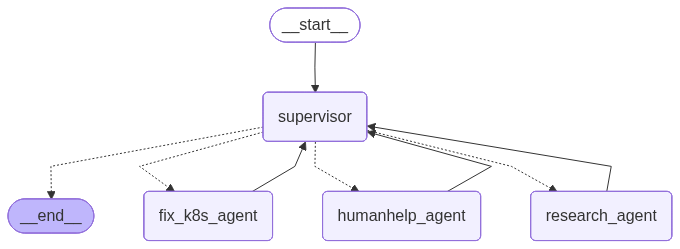

In [626]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [627]:
#pretty print
from langchain_core.messages import convert_to_messages
def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [628]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "deployment: nginx-badimage, namespace: default, event: Back-off pulling image 'nginx:latess'"
            }
        ]
    }
):
    print(chunk)

{'supervisor': {'messages': [HumanMessage(content="deployment: nginx-badimage, namespace: default, event: Back-off pulling image 'nginx:latess'", additional_kwargs={}, response_metadata={}, id='d1f4df15-41ad-4702-9368-8ff8e05ccc5b'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 457, 'total_tokens': 478, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'deepseek-ai/DeepSeek-V3', 'system_fingerprint': '', 'id': '019a631c1e2726c82d12acee6a651808', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='lc_run--941a13d0-7af2-451a-aa21-104ce880cb06-0', tool_calls=[{'name': 'transfer_to_fix_k8s_agent', 'args': {}, 'id': '019a631c23d119769f3e2e54300da1f2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 457, '